In [160]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [161]:
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
# TRAVILY_PROJECT = os.getenv("TRAVILY_PROJECT")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING")
os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT")
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT")

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")



In [162]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [163]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest")

In [164]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--82d196e8-f144-4f3a-8744-5fad7e8c842c-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [165]:

@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [166]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

In [167]:
tools=[search,multiply]

In [168]:
model_with_tools=llm.bind_tools(tools)

In [169]:

tool_mapping={tool.name: tool for tool in tools}

In [170]:

tool_mapping
     

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001E959C4D1B0>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001E959C82050>)}

In [171]:
response = model_with_tools.invoke("who is a current president of USA?")

In [172]:
response

AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "who is a current president of USA?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--8ef2982c-c561-4ead-900b-91e25596da88-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is a current president of USA?'}, 'id': '8bbd70c0-46f3-4a22-ac8b-27175b8c090b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 41, 'output_tokens': 10, 'total_tokens': 51, 'input_token_details': {'cache_read': 0}})

In [173]:


tool_details=response.additional_kwargs.get("function_call")
     

In [174]:
tool_details

{'name': 'search',
 'arguments': '{"query": "who is a current president of USA?"}'}

In [175]:

tool_details["name"]
     

'search'

In [176]:
tool_details["arguments"]

'{"query": "who is a current president of USA?"}'

In [177]:
json.loads(tool_details["arguments"])

{'query': 'who is a current president of USA?'}

In [178]:

tool_mapping[tool_details["name"]].invoke(json.loads(tool_details["arguments"]))

[{'title': 'Presidents, vice presidents, and first ladies | USAGov',
  'url': 'https://www.usa.gov/presidents',
  'content': 'Learn about the duties of president, vice president, and first lady of the United States. Find out how to contact and learn more about current and past leaders.\n\n## President of the United States\n\nThe president of the United States is the:\n\n### Current president\n\nThe 47th and current president of the United States is Donald John Trump. He was sworn into office on January 20, 2025.\n\n### Former U.S. presidents [...] The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. If the vice president is not able to fulfill the duties of president, the role is passed to another leader in the order of presidential succession.\n\n### Current vice president\n\nThe 50th and current vice president of the United States is James David (JD) Vance. H

In [179]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [180]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}
     

In [181]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("function_call", [])
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("name")}')
    
    if tool_details.get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['name']].invoke(json.loads(tool_details.get("arguments")))
    return {"messages" : [response]}
     

In [182]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("function_call", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [183]:
graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("ai_assistant", invoke_model)

graph.add_node("tool", invoke_tool)

In [184]:
graph.add_conditional_edges("ai_assistant", router, {"tool": "tool","end": END,})

graph.add_edge("tool", END)

#graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")

In [185]:
app = graph.compile()

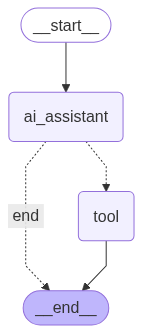

In [186]:


from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [187]:

for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "who is upcoming president of USA?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--55f9f954-6c01-48f0-9694-35811df0d037-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is upcoming president of USA?'}, 'id': 'b0563432-8443-4f4d-800c-e4a06dd2df35', 'type': 'tool_call'}], usage_metadata={'input_tokens': 40, 'output_tokens': 9, 'total_tokens': 49, 'input_token_details': {'cache_read': 0}})]}
----
Selected tool: search
{'messages': [[{'title': 'Order of presidential succession | USAGov', 'url': 'https://www.usa.gov/presidential-succession', 'content': 'The president of the United States may be replaced if he or she: Becomes incapacitated; Dies; Resigns; Is unable to hold office', 'score': 0.98591}, {'title': 'United States presidential li

In [188]:

for s in app.stream({"messages": ["multiply 3 and 4"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"second_number": 4.0, "first_number": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--7ceef44e-d9c9-406e-a065-0090b20f5fb6-0', tool_calls=[{'name': 'multiply', 'args': {'second_number': 4.0, 'first_number': 3.0}, 'id': '5dd76ebd-f9d3-45e4-83d7-d431a7abb0d7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 39, 'output_tokens': 9, 'total_tokens': 48, 'input_token_details': {'cache_read': 0}})]}
----
Selected tool: multiply
{'messages': [12]}
----


In [189]:

for s in app.stream({"messages": ["can you tell me th etotal money that exist in the world"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='I cannot calculate the total amount of money in the world.  The definition of "money" is complex and varies depending on what is included (e.g., physical currency, bank deposits, investments, derivatives). Also, the total amount is constantly changing due to economic activity.  I can provide information about specific measures of money supply if you have those in mind.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--45403d09-3aed-4a78-9c05-564c123dea09-0', usage_metadata={'input_tokens': 46, 'output_tokens': 75, 'total_tokens': 121, 'input_token_details': {'cache_read': 0}})]}
----


the above we have  cresateed haas been done by the halp of custom made function now we will go to the langgraph's interrupt before funtiojn

In [190]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [191]:
tavily=TavilySearchResults()

In [192]:

tools = [tavily]

In [193]:
llm_with_tools = llm.bind_tools(tools)


In [194]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [195]:
memory = MemorySaver()

In [196]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [197]:
graph_builder.add_edge(START, "ai_assistant")

graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

In [198]:
app2 = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

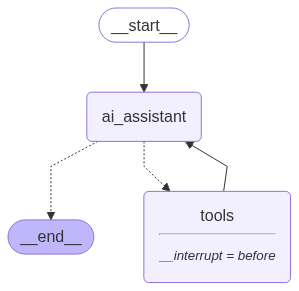

In [199]:

from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [200]:
user_input = "what is current a capital of india?"
config = {"configurable": {"thread_id": "1"}}

In [201]:

# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [202]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is current a capital of india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (766dec22-0d85-4d9f-8892-bcca563bed7e)
 Call ID: 766dec22-0d85-4d9f-8892-bcca563bed7e
  Args:
    query: what is current a capital of india?


In [203]:
snapshot = app2.get_state(config)

In [209]:

snapshot.next

('tools',)

In [210]:
last_message=snapshot.values["messages"][-1]

In [211]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'what is current a capital of india?'},
  'id': '766dec22-0d85-4d9f-8892-bcca563bed7e',
  'type': 'tool_call'}]

In [212]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [213]:

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
     

================================== Ai Message ==================================

New Delhi is the capital of India.


In [214]:
user_input = "what is a weather there?"

In [215]:

# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [216]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather there?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (5354be30-4a96-4e54-8a82-d0b21bf128c2)
 Call ID: 5354be30-4a96-4e54-8a82-d0b21bf128c2
  Args:
    query: weather in New Delhi


In [217]:
snapshot = app2.get_state(config)

In [218]:
snapshot.next

('tools',)

In [219]:
last_message=snapshot.values["messages"][-1]

In [220]:


# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")


In [221]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (5354be30-4a96-4e54-8a82-d0b21bf128c2)
 Call ID: 5354be30-4a96-4e54-8a82-d0b21bf128c2
  Args:
    query: weather in New Delhi
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "India rains LIVE: IMD issues red alert to several places in ...", "url": "https://www.thehindu.com/news/national/india-rains-telangana-delhi-kerala-uttarakhand-weather-live-updates-august-13-2025/article69927053.ece", "content": "Telangana faces heavy rainfall, IMD issues alerts, health minister directs hospitals to prepare for emergencies.    \n     \n   August 13, 2025 10:19  Delhi records minimum temperature of 26.8 degrees Celsius Delhi on Wednesday (August 13, 2025) recorded a minimum temperature of 26.8 degrees Celsius, with the weather office forecasting a generally cloudy sky with one or two spells of rain or 

In [222]:
app2.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is current a capital of india?', additional_kwargs={}, response_metadata={}, id='fc8c56f2-cd4f-4607-961b-2d30501023eb'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "what is current a capital of india?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--0585a81f-11e6-4a33-82f7-2a7cc7239f96-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'what is current a capital of india?'}, 'id': '766dec22-0d85-4d9f-8892-bcca563bed7e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 17, 'total_tokens': 74, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='[{"title": "What is the capital of India? States and union territories explained.", "url": "https://www.usatoday.com/s

In [223]:
snapshot=app2.get_state(config)

In [224]:
snapshot.next

()

In [225]:


user_input = "give me the recent news of it?"

In [226]:


# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [227]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the recent news of it?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc8f41e6-dcf9-4997-9039-ef8531a867ae)
 Call ID: fc8f41e6-dcf9-4997-9039-ef8531a867ae
  Args:
    query: recent news New Delhi


In [228]:
snapshot=app2.get_state(config)

In [229]:
current_message = snapshot.values["messages"][-1]

In [230]:
current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc8f41e6-dcf9-4997-9039-ef8531a867ae)
 Call ID: fc8f41e6-dcf9-4997-9039-ef8531a867ae
  Args:
    query: recent news New Delhi


In [231]:
tool_call_id = current_message.tool_calls[0]["id"] 

In [232]:
from langchain_core.messages import AIMessage, ToolMessage

In [233]:
answer = "it is just related to raining which is happing on daily basis"

In [234]:


new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [235]:

app2.update_state(
    config,
    {"messages": new_messages},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f078508-f706-6dcf-800c-f28533be44c2'}}

In [236]:


print(app2.get_state(config).values["messages"][-1:])

[AIMessage(content='it is just related to raining which is happing on daily basis', additional_kwargs={}, response_metadata={}, id='7efcf160-abb7-41db-871f-4ce2883561f2')]
